In [14]:
import copy
from datetime import datetime
import os
import sys
import time
sys.path.append("/home/diego/python/auditory-cortex/data/") 
sys.path.append("/home/diego/python/utils/") 

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
from torch.optim import Adam
# import seaborn as sns

from experiments.utils.plot import plot_layout_fit
from gglm.glm.base import GLM
from gglm.glm.torchglm import TorchGLM
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from gglm.glm.mmdglm import MMDGLM
# from gglm.kernels import phi_autocov
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
# from kernel.fun import KernelFun
# from kernel.rect import KernelRect
from kernel.values import KernelBasisValues
from signals import raw_autocorrelation
from torch.nn.functional import conv1d

from celldata import CellData

import myplt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxCalyx/20190918-xxx999-001-004/'
# path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxCalyx/'
# path = '/home/diego/storage/projects/auditory-cortex/data/ACx_data_2/ACxThelo/'
# l = os.listdir(path)
# cd = CellData(path + l[2])

# path = '/home/diego/storage/projects/auditory-cortex/data/ACx_data_1/ACxThelo/20180322-f006/'
path = '/home/diego/storage/projects/auditory-cortex/data/ACx_data_3/ACxCalyx/20200720-xxx999-001-002/'
# l = os.listdir(path)
cd = CellData(path)

t0bin, tfbin = 100, 1100

cd.df['end_stimulus'] = cd.df['trigger'] + cd.df['duration']
cd.df['next_trigger'] = np.append(cd.df.iloc[1:]['trigger'].values, float(cd.dt * cd.n_samples))
cd.df['after_stimulus_period'] = cd.df['next_trigger'] - cd.df['end_stimulus']

t_last_spk = cd.arg_spikes[-1, 0] * cd.dt

idx = list(cd.df[(cd.df['after_stimulus_period'] > tfbin) & (cd.df.trigger < t_last_spk)].index)

if len(idx) > 0:
    mask_spikes = cd.get_mask_spikes_after_stimulus(idx, t0=t0bin, tf=tfbin)
    
t = np.arange(mask_spikes.shape[0]) * cd.dt

In [16]:
# cd.df['next'] = np.append(cd.df.trigger.diff().values[1:], np.nan)

In [17]:
palette = dict(dc='dodgerblue', fr_ml='k', fr_mmd='C3')
# palette = dict(dc='k', fr_ml='dodgerblue', fr_mmd='C4')

In [18]:
def distance(r_dc, mask_spikes, r_fr, mask_spikes_fr):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
    r_dc, r_fr = r_dc / r_dc.shape[0], r_fr / r_fr.shape[0]
    n_batch_dc, n_batch_fr = r_dc.shape[1], r_fr.shape[1]
    r_sum_dc, r_sum_fr = torch.sum(r_dc, 1), torch.sum(r_fr, 1)
        
    norm2_dc = (torch.sum(r_sum_dc**2) - torch.sum(r_dc**2)) / (n_batch_dc * (n_batch_dc - 1))
    norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
    mean_dot = torch.sum(r_sum_dc * r_sum_fr, 0) / (n_batch_dc * n_batch_fr)
    d = (norm2_dc + norm2_fr - 2 * mean_dot)
    return d

lam_mmd = 1e0 # isi_mean
def kerneln_npsk(t, mask_spikes1, mask_spikes2):
    n_spk1 = torch.sum(mask_spikes1, 0).double()
    n_spk2 = torch.sum(mask_spikes2, 0).double()
    gramian = n_spk1[:, None] * n_spk2[None, :]
#     gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kerneln_npsk

# def phi_autocov2(t, mask_spikes, padding=200):
#     T = len(t)
#     mask_spikes = mask_spikes.double()
#     autocov = conv1d(mask_spikes.T[None, :, :], mask_spikes.T[:, None, :], padding=padding, groups=mask_spikes.shape[1]) / T
#     autocov = autocov[0, :, padding + 1:].T
#     return autocov

def phi_autocov(t, mask_spikes, padding=200):
#     mask = mask_spikes.numpy()
#     fr = np.sum(mask, 0) / (dt * mask.shape[0]) * 1000
#     mask = mask[:, fr < 50]
#     autocor = raw_autocorrelation(mask, biased=True)
    autocor = raw_autocorrelation(mask_spikes.numpy(), biased=True)
    autocor = torch.from_numpy(autocor[1:padding])
    return autocor

def fun_metrics_ml(self, t, mask_spikes, X):
    n_batch_fr = 100
    T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
    _, r_dc = self.sample_conditioned(st_val.t, st_val.mask)
    u_fr, r_fr, mask_spikes_fr = self.sample(st_val.t, shape=(n_batch_fr,))
    mmd = kerneln_npsk(st_val.t, mask_spikes, mask_spikes_fr)
    fr = np.mean(np.sum(mask_spikes_fr, 0) / T * 1000)
    return dict(fr=fr, mmd=mmd)

def fun_metrics_mmd(self, t, mask_spikes, X, n_batch_fr):
    T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
    _, r_dc = self.sample_conditioned(st_val.t, st_val.mask)
    u_fr, r_fr, mask_spikes_fr = self.sample(st_val.t, shape=(n_batch_fr,))
#     mmd = distance(torch.from_numpy(r_dc), st_val.mask, torch.from_numpy(r_fr), mask_spikes_fr)
    mask_spikes_fr = torch.from_numpy(mask_spikes_fr)
    mmd = kerneln_npsk(st_val.t, mask_spikes, mask_spikes_fr)
    u_fr, r_fr, mask_spikes_fr = self.sample(st_val.t, shape=(n_batch_fr,))
    fr = np.mean(np.sum(mask_spikes_fr, 0) / T * 1000)
    return dict(fr=fr, mmd=mmd)

def nll(self, t, mask_spikes, mask_spikes_fr):
    dt = 1
    mask = mask_spikes.numpy()
    _, r_dc = self.sample_conditioned(t, mask)
    neg_log_likelihood = -(np.sum(np.log(1 - np.exp(-dt * r_dc)) * mask) - \
                          dt * np.sum(r_dc * (1 - mask)))
    return dict(nll=neg_log_likelihood)

In [19]:
np.random.seed(2)

# dic_filter = {'type': 'tone'}
# t0, tf = -300, 400
# t0_val, tf_val = -300, 1800

# arg0, argf = int(t0 / cd.dt), int(tf / cd.dt)
# t = np.arange(0, argf - arg0, 1) * cd.dt

idx_train = np.arange(0, len(idx), 1)

dt = 1
mask_spikes_train = mask_spikes[:, idx_train]
t = np.arange(0, mask_spikes.shape[0], 1) * cd.dt
st_train = SpikeTrain(t, mask_spikes_train).subsample(dt)

t = st_train.t.copy()
mask_spikes_train = st_train.mask.copy()
n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)

autocor_train = np.mean(raw_autocorrelation(st_train.mask, biased=True), 1)

# arg0, argf = int(t0_val / cd.dt), int(tf_val / cd.dt)
# t = np.arange(0, argf - arg0, 1) * cd.dt
# mask_spikes_val = cd.get_mask_spikes_trials({'type': 'fmsweep'}, t0=t0_val, tf=tf_val)
# st_val = SpikeTrain(t, mask_spikes_val).subsample(1)

# T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
# fr_data = np.mean(np.sum(st_val.mask, 0) / T * 1000)

# tbins = [0, 4, 8, 16, 32, 64, 128, 256, 512]
# tbins = np.arange(0, 200, 2)
# eta = KernelRect(tbins=tbins, coefs=np.zeros(len(tbins) - 1))
# eta.coefs = np.array([-1.6,  0.7,  0.8,  0.5, -0.1, -0.3 , -0.7, -1])
# eta = KernelFun.exponential([2, 100], coefs=[0, 0])

num_epochs = 200
n_batch_fr = 100
# num_epochs = 5
# n_batch_fr = 5
# lam_mmd = 1e0
# lr = 5e-2

### ML

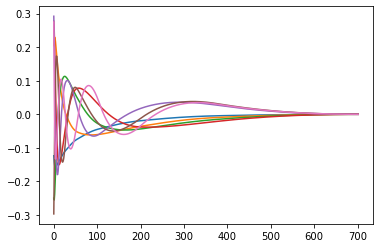

In [20]:
()# TorchGLM.metrics = fun_metrics_ml

lam_mmd = 1e0
lr = 1e-1
num_epochs = 150

# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 200, 7, 1e1, a=1) #8.74
# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 100, 7, 1e0, a=1) #9.24
# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 200, 7, 2e1, a=1) # 9.3
# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 100, 7, 1e1, a=1) # 9.8
eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 200, 7, 5e0, a=1) #8.22 best
# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 200, 7, 1e0, a=1) # 9.algo
# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 250, 7, 5e0, a=1) # 9.algo
# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 150, 7, 5e0, a=1) #8.5

# eta = KernelBasisValues.orthogonalized_raised_cosines(dt, 250, 7, 1e1, a=1) #9al
t_eta = np.arange(0, eta.basis_values.shape[0], 1) * dt

plt.plot(t_eta, eta.interpolate_basis(t_eta))

In [22]:
glm_ml = TorchGLM(u0=-4, eta=eta.copy())
# glm.metrics = fun_metrics_ml
optim = Adam(glm_ml.parameters(), lr=lr)
loss_ml, metrics_ml = glm_ml.train(t, torch.from_numpy(mask_spikes_train), optim=optim, num_epochs=num_epochs, verbose=True, metrics=None)
loss_ml = np.array(loss_ml)
nll_normed_train_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk_train
# _, r_val_dc_ml = glm_ml.sample_conditioned(st_val.t, st_val.mask)
# r_val_dc_ml = np.mean(r_val_dc_ml, 1)
_, r_fr_ml, mask_spikes_fr_ml = glm_ml.sample(t, shape=(100,))
# st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml[:, np.random.choice(n_batch_fr, size=)])
st_fr_ml = SpikeTrain(t, mask_spikes_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)

autocov_ml = np.mean(raw_autocorrelation(mask_spikes_fr_ml, biased=True), 1)

 epoch 149 of 150 loss 2867.9398

In [24]:
nll_normed_train_ml[-1]

-0.30430377844246287

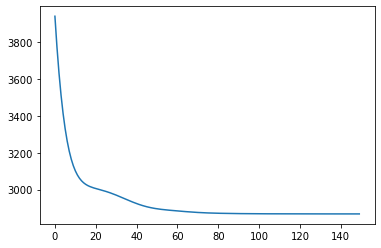

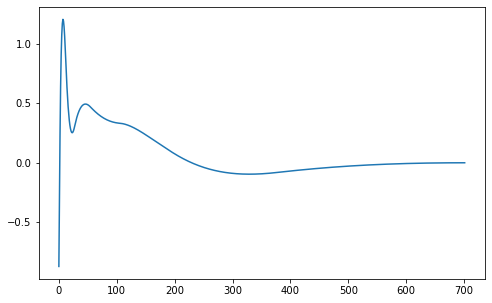

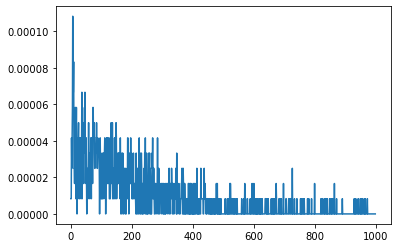

In [11]:
plt.plot(loss_ml)
glm_ml.eta.plot(t=t_eta)
plt.figure()
plt.plot(autocor_train[1:])
# plt.plot(autocov_ml[1:])

In [12]:
_, r_fr_ml, mask_spikes_fr_ml = glm_ml.sample(t, shape=(500,))
st_fr_ml = SpikeTrain(t, mask_spikes_fr_ml)

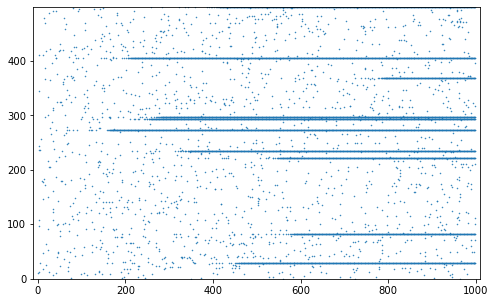

In [13]:
st_fr_ml.plot(ms=0.5)

### MMD

In [27]:
kernel_kwargs = None

phi, kernel, lam_mmd, biased, lr, n_batch_fr, num_epochs, initialization, kernel_kwargs = phi_autocov, None, 2e8, True, 2e-2, 400, 200, 'zero', dict(padding=250)

beta0, beta1, clip = 0, 0, None
# beta0, beta1, clip = 0.999, 0, 5e-1
n_metrics = 1
log_likelihood, metrics = True, nll
# log_likelihood, metrics = True, None
control_variates = False

dtime = datetime.now()
dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

time0 = time.time()
u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()
if initialization == 'zero':
    eta0.coefs = eta0.coefs * 0

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1), amsgrad=False)

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=log_likelihood,
                                               n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, kernel_kwargs=kernel_kwargs, optim=optim, clip=clip, 
                                                num_epochs=num_epochs,
                                              verbose=True, metrics=metrics, n_metrics=n_metrics, control_variates=control_variates)

if len(nll_train) != 0:
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
else:
    loss_mmd, nll_train = np.array(loss_mmd), np.array(metrics_mmd['nll'])

# _, r_dc_mmd_val = mmdglm.sample_conditioned(t, st_val.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(t, shape=(8000,))
st_fr_mmd = SpikeTrain(t, mask_spikes_fr_mmd)
fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000

# print(np.max(fr_mmd), np.mean(fr_mmd), np.mean(fr_mmd**2), np.std(fr_mmd))
# print(np.std(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000), np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2))

isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
autocor_mmd = np.mean(raw_autocorrelation(mask_spikes_fr_mmd, biased=True), 1)

 epoch 199 of 200 loss 3352.48330533071767

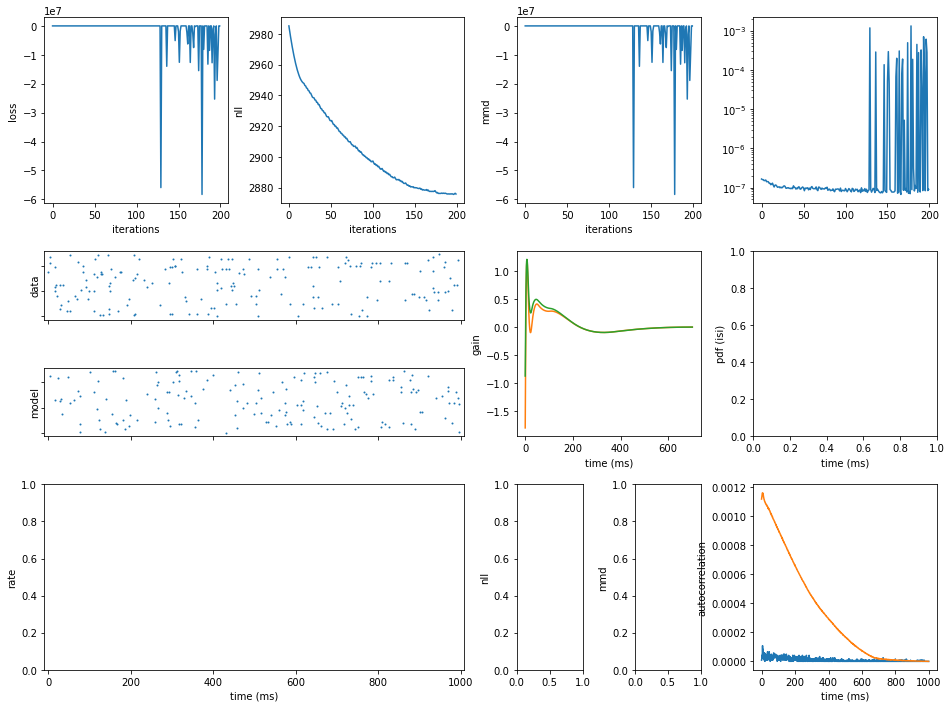

In [28]:
fig, (axloss, axnlli, axmmdi, axextra, axd, axfr, axeta, axisi, axpsth, axnll, axmmd, axac) = plot_layout_fit(figsize=(16, 12))

axloss.plot(loss_mmd)
axnlli.plot(nll_train)

axmmdi.plot(loss_mmd - nll_train)
# axmmdi.set_yscale('log')

axextra.plot(metrics_mmd['mmd'])
axextra.set_yscale('log')

st_train.sweeps(np.arange(50)).plot(ax=axd, ms=1)

st_fr_mmd.sweeps(np.arange(50)).plot(ax=axfr, ms=1)

mmdglm.eta.plot(t=t_eta, ax=axeta, color='C1')
glm_ml.eta.plot(t=t_eta, ax=axeta, color='C2')

isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)

# t_ac = np
axac.plot(autocor_train[1:])
axac.plot(autocor_mmd[1:])

<AxesSubplot:>

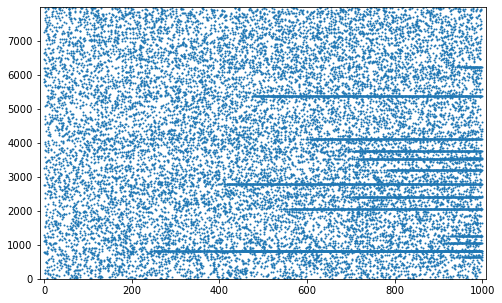

In [66]:
st_fr_mmd.plot(ms=1)

In [25]:
plt.plot(autocov_train[1:400])
plt.plot(autocov_mmd[1:400])

np.sum((autocov_train[1:] - autocov_mmd[1:])**2)
# plt.plot(autocov_ml[1:])

NameError: name 'autocov_train' is not defined

In [70]:
metrics_mmd['mmd'][-1] * 1e8

19.206388888888892

In [27]:
plt.plot(autocov_train[1:])
plt.plot(autocov_mmd[1:])

np.sum((autocov_train[1:] - autocov_mmd[1:])**2)
# plt.plot(autocov_ml[1:])

NameError: name 'autocov_train' is not defined

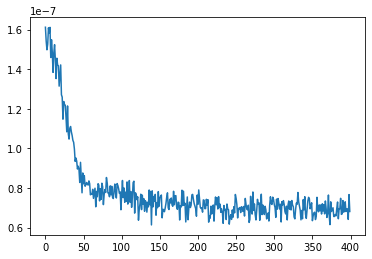

In [28]:
fig, ax = plt.subplots()
ax.plot(metrics_mmd['mmd'])

<AxesSubplot:>

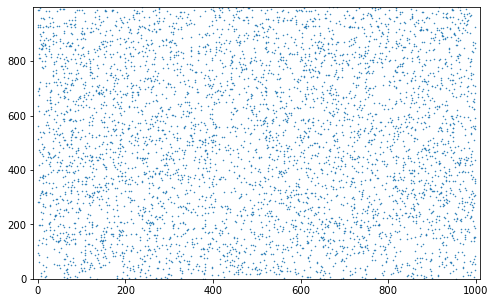

In [29]:
st_fr_mmd.plot(ms=0.5)

In [67]:

lr, num_epochs = 1e-1, 20
n_batch_fr = 100

lr = torch.ones(num_epochs) * 1e-3

# mask_spikes_train_torch = torch.from_numpy(st_train.mask).double()

# mmdglm = MMDGLM(u0=-4, eta=eta.copy())
mmdglm = MMDGLM(u0=glm.u0, eta=glm.eta.copy())
# mmdglm.metrics = fun_metrics_ml
# optim = Adam(mmdglm.parameters(), lr=lr)
loss_mmd, mmd, metrics_mmd = mmdglm.train(st_train.t, mask_spikes_train, phi=phi, kernel=kernel, lr=lr, lam_mmd=lam_mmd, 
                                          num_epochs=num_epochs, verbose=True, n_batch_fr=n_batch_fr, metrics=fun_metrics_mmd)
loss_mmd, mmd = np.array(loss_mmd), np.array(mmd)

_, r_val_dc_mmd = mmdglm.sample_conditioned(st_val.t, st_val.mask)
r_val_dc_mmd = np.mean(r_val_dc_mmd, 1)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)
# mean_r_fr_mmd = np.mean(r_fr_mmd, 1)

TypeError: train() got an unexpected keyword argument 'lr'